# Hill Climbing

This notebook demonstrates a simple hill climbing algorithm with adaptive noise scaling using OpenAI Gym's CartPole environment

This is just a toy example which uses **env.seed(0)** to show the algorithim and is **NOT A SOLUTION**

In [1]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.functional as F

## Explore Environment

The shape of the state and action space

In [2]:
env = gym.make('CartPole-v0')
print(f'State Space: {env.observation_space}')
print(f'State Space Shape: {env.observation_space.shape}')
print(f'Action Space: {env.action_space}')

State Space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
State Space Shape: (4,)
Action Space: Discrete(2)


## WeightModifier

This is a base class for all agents that require their weight to be modified externally rather than using an optimizer for training the agent

In [3]:
from typing import List

class WeightModifier:
    """
    Given a flat weights array, this class can disribute the array weights to individual
    layer components.
    
    Total number of weights required can be found by calling get_weights_dim() method
    """
    def _set_layers(self, layers: List[nn.Linear]):
        """
        All layers of the network are saved in an array and indices are computed to be used
        later to copy weights from a flat numpy array containing weights for all of the 
        layers.
        """
        self.layers = layers
        self.w_indices = []
        idx_start = 0
        for l in self.layers:
            indices = self._w_b_indices(l, idx_start)
            self.w_indices.append((idx_start, *indices))
            idx_start = indices[1]
            
    def _w_b_indices(self, layer, start):
        """
        returns the indices in the weights array where the given layer's 
        weights and biases are to be copied from
        """
        w = np.prod(layer.weight.shape)   # e.g. 4 layer with 2 input would be (4,2)=8 shape
        b = layer.bias.shape[0]           # bias only has as many as neurons in this layer
        return start + w, start + w + b

    def _set_layer_weights_(self, layer, weights, layer_no):
        start, layer_w, layer_b = self.w_indices[layer_no]
        
        # pick up weights and biases from the weights array passed in
        w = weights[start: layer_w]
        b = weights[layer_w: layer_b]
        
        # change weight and bias of the given layer
        layer.weight.data.copy_(torch.from_numpy(w).view(layer.weight.shape))
        layer.bias.data.copy_(torch.from_numpy(b).view(layer.bias.shape))
        
        # returns the index where next layer's weights will start from
        return layer_b
    
    def set_weights(self, weights):
        index = 0
        for idx, l in enumerate(self.layers):
            self._set_layer_weights_(l, weights, idx)

    def get_weights(self):
        w = np.zeros(self.get_weights_dim())
        for idx, l in enumerate(self.layers):
            i = self.w_indices[idx]
            w[i[0] : i[1]] = l.weight.data.cpu().detach().numpy().reshape(-1)
            w[i[1] : i[2]] = l.bias.data.cpu().detach().numpy().reshape(-1)
        return np.array(w)
        
    def get_weights_dim(self):
        return self.w_indices[-1][2]
    
    def gen_random(self, sigma = 1.):
        return sigma * np.random.rand(self.get_weights_dim())

## Agent Definition

Any agent to be used by hill_climbing algorithm needs:

1. an `act` method that should return an action index to be used
2. `set_weights` method to set new weights on it
3. `get_weights_dim` to find out how many random numbers are to be generated
4. `get_weights for` the hill climbing algorithm to find out existing weights

In [4]:
# A PyTorch based agent
class Agent(nn.Module, WeightModifier):
    def __init__(self, env):
        super().__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        
        self.fc1 = nn.Linear(self.state_space, 8)
        self.fc2 = nn.Linear(8, self.action_space)
        
        super()._set_layers([self.fc1, self.fc2])
        
    def forward(self, X):
        X_tensor = torch.from_numpy(X).float().to(self.fc1.weight.device)
        output = torch.relu(self.fc1(X_tensor))
        output = self.fc2(output)
        return torch.softmax(output, dim = 0)
    
    def act(self, state):
        with torch.no_grad():
            prob = self.forward(state)
        return int(torch.argmax(prob).cpu().detach().numpy())
    
# A simple agent that does not use PyTorch and just implements X @ W (np.dot(x, W))
class SimplePolicyAgent:
    def __init__(self, env, factor = 1e-4):
        self.w = factor * np.random.rand(env.observation_space.shape[0], env.action_space.n)
        
    def forward(self, state):
        wx = state @ self.w
        return np.exp(wx) / np.sum(np.exp(wx))
    
    def act(self, state):
        probs = self.forward(state)
        return np.argmax(probs)
    
    def set_weights(self, w):
        self.w = w.reshape(self.w.shape)
        
    def get_weights(self):
        return self.w.reshape(-1)
    
    def get_weights_dim(self):
        return np.prod(self.w.shape)
    

## Confirm set_weights is correctly implemented

Make sure that the new weights are correctly set on each layer

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

env = gym.make('CartPole-v0')
a = Agent(env).to(device)

first_layer = (env.observation_space.shape[0] + 1) * 8
second_layer = (8 + 1) * env.action_space.n

assert a.get_weights_dim() == first_layer + second_layer, "get_weights_dim is not correctly implemented"

fc1_w = np.random.rand(env.observation_space.shape[0] * 8)
fc1_b = np.random.rand(8)
fc2_w = np.random.rand(8 * env.action_space.n)
fc2_b = np.random.rand(env.action_space.n)

w = np.hstack([fc1_w, fc1_b, fc2_w, fc2_b])
a.set_weights(w)

assert np.all(abs(fc1_w - a.fc1.weight.data.cpu().detach().numpy().reshape(-1)) < 0.0001)
assert np.all(abs(fc1_b - a.fc1.bias.data.cpu().detach().numpy().reshape(-1)) < 0.0001)
assert np.all(abs(fc2_w - a.fc2.weight.data.cpu().detach().numpy().reshape(-1)) < 0.0001)
assert np.all(abs(fc2_b - a.fc2.bias.data.cpu().detach().numpy().reshape(-1)) < 0.0001)

assert np.all(abs(a.get_weights() - w) < 0.0001)

print('Passed')

Using device: cuda
Passed


## Hill Climbing with Adaptive Noise

In [76]:
from collections import deque

def run_episode(agent: Agent, env, gamma: float, max_t = 1000) -> (float, float, int):
    score = 0
    ep_reward = 0
    state = env.reset()
    gamma_t = 1
    
    for t in range(max_t):
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        
        # accumulate score and discounted rate
        score += reward
        ep_reward += reward * gamma_t
        gamma_t *= gamma
        
        if done:
            break
    return score, ep_reward

def hill_climbing(agent: Agent, env, min_score : float, 
                  n_episodes : int = 1000, max_t : int = 1000, 
                  gamma : float = 1., noise_scale : float = 1e-2, print_every : int = 100) -> List[float]:
    scores = []
    scores_100 = deque(maxlen = 100)
    for i in range(100):
        scores_100.append(0)
    best_w = agent.get_weights()
    best_reward = -np.Inf
    
    for ep_no in range(n_episodes):
        ep_score, ep_reward = run_episode(agent, env, gamma, max_t)
        
        scores_100.append(ep_score)
        scores.append(ep_score)

        if np.mean(scores_100) >= min_score:
            break

        if ep_reward >= best_reward:
            best_reward = ep_reward
            best_w = agent.get_weights()
            
            noise_scale = max(1e-3, noise_scale / 2.)
        else:
            # the new weights were not better than the best weights, so we 
            # need to now expand our range
            noise_scale = min(2, noise_scale * 2.)

        w = best_w + noise_scale * np.random.rand(agent.get_weights_dim())
        agent.set_weights(w)
    
        if (ep_no + 1) % print_every == 0:
            print(f'\rEp {ep_no + 1}: {np.mean(scores_100)}', end='')
    
    if np.mean(scores_100) < min_score:
        print(f'\nEnv could not be solved in the given episodes')
    else:
        print(f'\nEnv solved in {ep_no - 100} episodes, mean score = {np.mean(scores_100)}')
        
    return scores

env = gym.make('CartPole-v0')
env.seed(0)
np.random.seed(0)

agent = SimplePolicyAgent(env)

scores = hill_climbing(agent, env, 195, n_episodes = 1000)

Ep 100: 175.07
Env solved in 12 episodes, mean score = 196.49


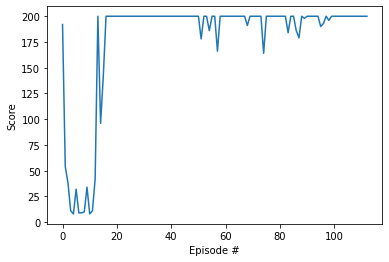

In [80]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(scores)), scores)
plt.xlabel('Episode #')
plt.ylabel('Score')
plt.show()

In [ ]:
import gym
env = gym.make('CartPole-v0')
env.seed(0)
np.random.seed(0)

for i_episode in range(20):
    state = env.reset()
    
    for t in range(100):
        env.render()
        action = agent.act(state)
        state, reward, done, info = env.step(action)
        
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
            
env.close()